# NB05: SetFit Few-shot Classification

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/RJuro/unistra-nlp2026/blob/main/notebooks/NB05_setfit_fewshot.ipynb)

**Duration:** 70 minutes

> **GPU recommended** — go to **Runtime → Change runtime type → T4 GPU**. SetFit fine-tunes a sentence transformer via contrastive learning — GPU speeds this up significantly, especially for the label efficiency experiments in Section 5.

## Learning Goals

By the end of this notebook, you will be able to:

1. **Train classifiers with only 8--32 labeled examples** using SetFit, a few-shot learning framework built on sentence transformers.
2. **Understand contrastive learning** -- how SetFit constructs positive and negative sentence pairs to fine-tune an embedding model with minimal supervision.
3. **Bootstrap training pairs with LLMs** -- use a large language model to paraphrase and augment your tiny labeled set, creating additional contrastive pairs.
4. **Measure label efficiency** -- compare SetFit against traditional baselines (TF-IDF + Logistic Regression) across different training-set sizes, and reason about when few-shot methods pay off.

---

In [1]:
!pip install setfit "transformers>=4.40,<5" openai pandas scikit-learn tqdm -q

# Colab pre-installs transformers v5, which removed a function SetFit depends on.
# After the install above downgrades transformers, we must restart the runtime.
import importlib, sys
if "setfit" in sys.modules:
    # Already imported in a previous run — need a full restart
    print("⚠️  Please restart the runtime: Runtime → Restart runtime, then re-run all cells.")
else:
    # First run — try importing to verify
    try:
        import setfit
        print(f"setfit {setfit.__version__} loaded successfully.")
    except ImportError:
        import os
        os.kill(os.getpid(), 9)  # auto-restart runtime

setfit 1.1.3 loaded successfully.


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [1]:
# Core imports
from setfit import SetFitModel, SetFitTrainer
from datasets import load_dataset, Dataset

import pandas as pd
import numpy as np
from sklearn.metrics import classification_report, accuracy_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

from openai import OpenAI
from tqdm.auto import tqdm

import os
import json
import random
import warnings
warnings.filterwarnings("ignore")

print("All imports successful.")

All imports successful.


In [3]:
# ── GPU Check ─────────────────────────────────────────────────────────────
import torch

if torch.cuda.is_available():
    print(f"GPU available: {torch.cuda.get_device_name(0)}")
else:
    print("No GPU detected — running on CPU.")
    print("SetFit training will be slower but still works (~2-5 min per experiment).")
    print("To enable GPU: Runtime → Change runtime type → T4 GPU")

GPU available: Tesla T4


## 1. The Task: Detecting Environmental Claims

Companies frequently make environmental or "green" claims in their public communications -- annual reports, press releases, sustainability disclosures. Some of these are substantive; many are vague or misleading ("greenwashing").

**Can we build a classifier to detect environmental claims with minimal labeled data?**

We will use the [climatebert/environmental_claims](https://huggingface.co/datasets/climatebert/environmental_claims) dataset, which contains sentences labeled as:

| Label | Meaning |
|-------|---------|
| **0** | Not an environmental claim |
| **1** | Environmental claim |

In a real-world scenario, you might be a regulator or researcher who has time to label only a handful of examples. This is exactly where few-shot learning shines.

In [4]:
from datasets import load_dataset

dataset = load_dataset("climatebert/environmental_claims")
print(dataset)
print(f"\nTrain size: {len(dataset['train'])}")
print(f"Test size: {len(dataset['test'])}")

# Look at examples
train_df = dataset['train'].to_pandas()
print(f"\nLabel distribution:\n{train_df['label'].value_counts()}")
print(f"\nExample claim:")
print(train_df[train_df.label == 1].iloc[0]['text'][:200])
print(f"\nExample non-claim:")
print(train_df[train_df.label == 0].iloc[0]['text'][:200])

README.md: 0.00B [00:00, ?B/s]

data/train-00000-of-00001-98aa5228a06a17(…):   0%|          | 0.00/215k [00:00<?, ?B/s]

data/validation-00000-of-00001-2553e47d4(…):   0%|          | 0.00/28.9k [00:00<?, ?B/s]

data/test-00000-of-00001-79fd931297fff76(…):   0%|          | 0.00/28.5k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/2117 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/265 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/265 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 2117
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 265
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 265
    })
})

Train size: 2117
Test size: 265

Label distribution:
label
0    1585
1     532
Name: count, dtype: int64

Example claim:
The project will make a significant contribution to the German and European hydrogen strategy and hence to achievement of the climate targets.

Example non-claim:
So in -- first of all, the segments, we are -- we are more selective than we were in the past.


## 2. The Few-shot Challenge

What happens when you only have **8 labeled examples**? Traditional machine-learning classifiers struggle badly:

- **TF-IDF + Logistic Regression** needs hundreds or thousands of examples to learn reliable word-level patterns.
- **Fine-tuning a BERT-style model** on 8 examples will massively overfit -- the model has ~110M parameters but only 8 gradient signals.
- **Zero-shot prompting** (e.g., with GPT-4) can work, but it is slow, expensive, and hard to deploy at scale.

**SetFit** fills this gap. It leverages **contrastive learning** to squeeze maximum signal from every labeled example, achieving results competitive with full fine-tuning while needing orders of magnitude fewer labels.

| Method | Labels needed | Accuracy (typical) |
|--------|:------------:|:-------------------:|
| TF-IDF + LR | 500+ | Moderate |
| Fine-tuned BERT | 200+ | High |
| SetFit | **8--32** | **High** |
| Zero-shot LLM | 0 | Variable |

## 3. SetFit: How It Works

SetFit (**S**entence-**T**ransformer **F**ine-tuning) is a two-phase framework designed for few-shot text classification:

### Phase 1: Contrastive Fine-tuning of the Sentence Transformer

Given your few labeled examples, SetFit generates **sentence pairs**:

- **Positive pairs**: two sentences with the **same** label. The model learns to pull their embeddings **closer** together.
- **Negative pairs**: two sentences with **different** labels. The model learns to push their embeddings **further apart**.

From just 8 examples (4 per class), SetFit can generate many contrastive pairs:
- Positive pairs from class 0: C(4,2) = 6 pairs
- Positive pairs from class 1: C(4,2) = 6 pairs
- Negative pairs: 4 x 4 = 16 pairs

With the `num_iterations` parameter, even more pairs are sampled with replacement. This is the key insight: **contrastive learning multiplies your labeled data**.

### Phase 2: Train a Classification Head

Once the sentence transformer is fine-tuned, SetFit:
1. Encodes all few-shot examples using the fine-tuned model.
2. Trains a simple **logistic regression** classifier on the resulting embeddings.

This two-phase approach is fast (no large LM fine-tuning needed), data-efficient, and produces a compact, deployable model.

![SetFit Pipeline](https://raw.githubusercontent.com/RJuro/unistra-nlp2026/main/notebooks/figures/setfit_pipeline.png)

In [5]:
def sample_few_shot(dataset, n_per_class, seed=42):
    """Sample n examples per class for few-shot training."""
    import random
    random.seed(seed)

    train_data = dataset['train'].to_pandas()
    samples = []
    for label in sorted(train_data['label'].unique()):
        class_data = train_data[train_data.label == label]
        selected = class_data.sample(n=min(n_per_class, len(class_data)), random_state=seed)
        samples.append(selected)

    return pd.concat(samples).reset_index(drop=True)

# Create few-shot sets
few_shot_8 = sample_few_shot(dataset, n_per_class=4)    # 8 total (4 per class)
few_shot_16 = sample_few_shot(dataset, n_per_class=8)   # 16 total
few_shot_32 = sample_few_shot(dataset, n_per_class=16)  # 32 total

print(f"8-shot:  {len(few_shot_8)} examples")
print(f"16-shot: {len(few_shot_16)} examples")
print(f"32-shot: {len(few_shot_32)} examples")

# Preview the 8-shot set
print("\n--- 8-shot training set ---")
for i, row in few_shot_8.iterrows():
    label_name = "CLAIM" if row['label'] == 1 else "NO CLAIM"
    print(f"  [{label_name}] {row['text'][:80]}...")

8-shot:  8 examples
16-shot: 16 examples
32-shot: 32 examples

--- 8-shot training set ---
  [NO CLAIM] OPG makes contributions to the Nuclear Segregated Funds based on the approved ON...
  [NO CLAIM] But right now, our focus and our intensity is on fixing the U.S., and we'll addr...
  [NO CLAIM] We have considerable potential to exert influ- ence and also to stipulate high e...
  [NO CLAIM] They are the levers on which we rely to achieve our ambition of becoming the res...
  [CLAIM] The 10 MW lithium-ion ESS captures excess solar energy produced during the day a...
  [CLAIM] In December 2020, as part of this work, AXA announced its commitment to reduce t...
  [CLAIM] These focus on improving water efficiency, reducing waste generation and increas...
  [CLAIM] Climate matters to Nordea As a large fnancial institution, Nordea is expected by...


## 4. Training SetFit with 8 Examples

Let us train a SetFit model using only our 8-shot training set. We use `paraphrase-mpnet-base-v2` as the base sentence transformer -- it is a strong general-purpose model that maps sentences to 768-dimensional embeddings.

In [6]:
from setfit import SetFitModel, SetFitTrainer
from datasets import Dataset

# Convert to HF dataset format
train_ds = Dataset.from_pandas(few_shot_8[['text', 'label']])
test_ds = dataset['test']

# Load pre-trained sentence transformer
model = SetFitModel.from_pretrained("sentence-transformers/paraphrase-mpnet-base-v2")

# Create trainer
trainer = SetFitTrainer(
    model=model,
    train_dataset=train_ds,
    eval_dataset=test_ds,
    metric="accuracy",
    num_iterations=20,   # Number of text pairs to generate per example
    num_epochs=1,        # Epochs for contrastive fine-tuning
)

# Train!
print("Training SetFit on 8 examples...")
trainer.train()

# Evaluate
metrics = trainer.evaluate()
print(f"\n8-shot SetFit Accuracy: {metrics['accuracy']:.1%}")

config.json:   0%|          | 0.00/594 [00:00<?, ?B/s]

modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


Map:   0%|          | 0/8 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 320
  Batch size = 16
  Num epochs = 1


Training SetFit on 8 examples...


wandb: (1) Create a W&B account
wandb: (2) Use an existing W&B account
wandb: (3) Don't visualize my results
wandb: Enter your choice:

wandb: Enter your choice:

 3


wandb: You chose "Don't visualize my results"
wandb: Using W&B in offline mode.
wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin


wandb: Detected [openai] in use.
wandb: Use W&B Weave for improved LLM call tracing. Install Weave with `pip install weave` then add `import weave` to the top of your script.
wandb: For more information, check out the docs at: https://weave-docs.wandb.ai/


Step,Training Loss
1,0.249500


***** Running evaluation *****



8-shot SetFit Accuracy: 59.6%


In [7]:
from sklearn.metrics import classification_report

test_df = dataset['test'].to_pandas()
predictions = model.predict(test_df['text'].tolist())

print("=" * 60)
print("SetFit (8-shot) -- Full Evaluation on Test Set")
print("=" * 60)
print(classification_report(test_df['label'], predictions,
                            target_names=['No claim', 'Environmental claim']))

SetFit (8-shot) -- Full Evaluation on Test Set
                     precision    recall  f1-score   support

           No claim       0.99      0.46      0.63       198
Environmental claim       0.38      0.99      0.55        67

           accuracy                           0.60       265
          macro avg       0.69      0.72      0.59       265
       weighted avg       0.84      0.60      0.61       265



## 5. Label Efficiency: How Many Examples Do We Need?

A key question in practical NLP: **how many labeled examples are enough?**

We will run experiments with 4, 8, 16, and 32 examples per class and compare:
- **SetFit** (contrastive fine-tuning + logistic head)
- **TF-IDF + Logistic Regression** (a strong traditional baseline)

This gives us a **label efficiency curve** -- one of the most useful plots for deciding how much annotation effort to invest.

In [11]:
def train_and_evaluate_setfit(few_shot_df, test_dataset, n_per_class):
    """Train a SetFit model on few-shot data and return accuracy."""
    train_ds = Dataset.from_pandas(few_shot_df[['text', 'label']])
    model = SetFitModel.from_pretrained("sentence-transformers/paraphrase-mpnet-base-v2")
    trainer = SetFitTrainer(
        model=model,
        train_dataset=train_ds,
        eval_dataset=test_dataset,
        metric="accuracy",
        num_iterations=20,
        num_epochs=2,
    )
    trainer.train()
    return trainer.evaluate()['accuracy']

def train_and_evaluate_tfidf(few_shot_df, test_texts, test_labels):
    """Train a TF-IDF + LR baseline and return accuracy."""
    tfidf_pipe = Pipeline([
        ('tfidf', TfidfVectorizer(max_features=5000, stop_words='english')),
        ('clf', LogisticRegression(max_iter=1000))
    ])
    tfidf_pipe.fit(few_shot_df['text'], few_shot_df['label'])
    return tfidf_pipe.score(test_texts, test_labels)

In [12]:
results = []

for n_per_class in [4, 8, 16, 32]:
    print(f"\n{'='*50}")
    print(f"Training with {n_per_class} examples per class ({n_per_class*2} total)")
    print(f"{'='*50}")

    few_shot = sample_few_shot(dataset, n_per_class=n_per_class)

    setfit_acc = train_and_evaluate_setfit(few_shot, dataset['test'], n_per_class)
    tfidf_acc = train_and_evaluate_tfidf(few_shot, test_df['text'], test_df['label'])

    results.append({
        'n_examples': n_per_class * 2,
        'setfit_accuracy': setfit_acc,
        'tfidf_accuracy': tfidf_acc
    })
    print(f"{n_per_class*2} examples -- SetFit: {setfit_acc:.1%}, TF-IDF: {tfidf_acc:.1%}")

results_df = pd.DataFrame(results)
print("\n" + "="*50)
print("Summary")
print("="*50)
print(results_df.to_string(index=False))


Training with 4 examples per class (8 total)


model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


Map:   0%|          | 0/8 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 320
  Batch size = 16
  Num epochs = 2


Step,Training Loss
1,0.249500


***** Running evaluation *****


8 examples -- SetFit: 52.1%, TF-IDF: 32.5%

Training with 8 examples per class (16 total)


model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


Map:   0%|          | 0/16 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 640
  Batch size = 16
  Num epochs = 2


Step,Training Loss
1,0.242200
50,0.087400


***** Running evaluation *****


16 examples -- SetFit: 65.3%, TF-IDF: 62.6%

Training with 16 examples per class (32 total)


model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


Map:   0%|          | 0/32 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 1280
  Batch size = 16
  Num epochs = 2


Step,Training Loss
1,0.367300
50,0.144500
100,0.000900
150,0.000300


***** Running evaluation *****


32 examples -- SetFit: 64.9%, TF-IDF: 60.8%

Training with 32 examples per class (64 total)


model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


Map:   0%|          | 0/64 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 2560
  Batch size = 16
  Num epochs = 2


Step,Training Loss
1,0.424700
50,0.200900
100,0.005300
150,0.000400
200,0.000200
250,0.000200
300,0.000200


***** Running evaluation *****


64 examples -- SetFit: 75.1%, TF-IDF: 67.5%

Summary
 n_examples  setfit_accuracy  tfidf_accuracy
          8         0.520755        0.324528
         16         0.652830        0.626415
         32         0.649057        0.607547
         64         0.750943        0.675472


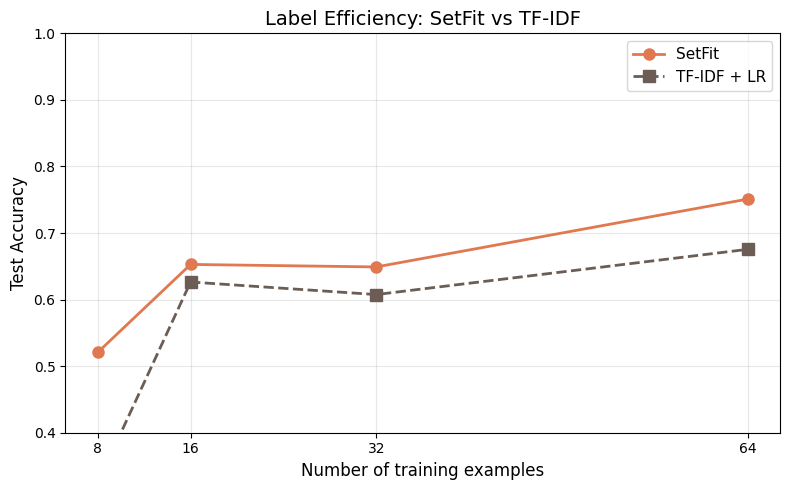

In [13]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(8, 5))
ax.plot(results_df['n_examples'], results_df['setfit_accuracy'],
        'o-', label='SetFit', color='#E07850', linewidth=2, markersize=8)
ax.plot(results_df['n_examples'], results_df['tfidf_accuracy'],
        's--', label='TF-IDF + LR', color='#6B5D55', linewidth=2, markersize=8)

ax.set_xlabel('Number of training examples', fontsize=12)
ax.set_ylabel('Test Accuracy', fontsize=12)
ax.set_title('Label Efficiency: SetFit vs TF-IDF', fontsize=14)
ax.legend(fontsize=11)
ax.set_ylim(0.4, 1.0)
ax.set_xticks(results_df['n_examples'])
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 6. Bonus: LLM-Bootstrapped Training Pairs

One powerful idea: **use an LLM to augment your few-shot training set**.

The recipe:
1. Take each of your 8 labeled examples.
2. Ask an LLM to **paraphrase** each one, preserving the meaning (and therefore the label).
3. Train SetFit on the augmented set (now 16 examples instead of 8).

This is a form of **data augmentation** that goes beyond simple synonym replacement -- the LLM can restructure sentences, change phrasing, and introduce natural variation.

Why does this help SetFit specifically?
- More examples means **more contrastive pairs** can be generated.
- Paraphrases create diverse positive pairs that teach the model what variation within a class looks like.

> **Note:** This cell requires a Groq API key. If you do not have one, you can skip it -- the rest of the notebook works without it.

In [19]:
GROQ_API_KEY = ""  # @param {type:"string"}

# If not set above, try Colab secrets → then environment variable
if not GROQ_API_KEY:
    try:
        from google.colab import userdata
        GROQ_API_KEY = userdata.get('GROQ_API_KEY')
    except (ImportError, Exception):
        GROQ_API_KEY = os.environ.get("GROQ_API_KEY", "")

if GROQ_API_KEY:
    client = OpenAI(api_key=GROQ_API_KEY, base_url="https://api.groq.com/openai/v1")

    def generate_paraphrase(text, label_name):
        """Generate a paraphrase of an example for data augmentation."""
        response = client.chat.completions.create(
            model="openai/gpt-oss-20b",
            messages=[{
                "role": "user",
                "content": (
                    f"Paraphrase this {label_name} text. "
                    f"Keep the same meaning but change the wording. "
                    f"Return ONLY the paraphrase.\n\nOriginal: {text}"
                )
            }],
            temperature=0.7,
            max_tokens=1024
        )
        return response.choices[0].message.content.strip()

    print("API connected. generate_paraphrase() ready.")
else:
    print("Set GROQ_API_KEY to try LLM bootstrapping.")
    print("You can get a free key at https://console.groq.com/")

API connected. generate_paraphrase() ready.


In [20]:
if GROQ_API_KEY:
    augmented = []
    label_names = {0: "non-environmental-claim", 1: "environmental claim"}

    print("Generating LLM paraphrases...")
    for _, row in tqdm(few_shot_8.iterrows(), total=len(few_shot_8)):
        # Keep original
        augmented.append({'text': row['text'], 'label': row['label']})
        # Generate paraphrase
        para = generate_paraphrase(row['text'], label_names[row['label']])
        augmented.append({'text': para, 'label': row['label']})
        print(f"  Original:    {row['text'][:70]}...")
        print(f"  Paraphrase:  {para[:70]}...")
        print()

    augmented_df = pd.DataFrame(augmented)
    print(f"\nAugmented from {len(few_shot_8)} to {len(augmented_df)} examples")
    print(f"Label distribution: {augmented_df['label'].value_counts().to_dict()}")
else:
    print("Skipping -- no GROQ_API_KEY set.")

Generating LLM paraphrases...


  0%|          | 0/8 [00:00<?, ?it/s]

  Original:    OPG makes contributions to the Nuclear Segregated Funds based on the a...
  Paraphrase:  OPG contributes to the Nuclear Segregated Funds in line with the appro...

  Original:    But right now, our focus and our intensity is on fixing the U.S., and ...
  Paraphrase:  At present, we are putting all our energy into fixing the U.S., and we...

  Original:    We have considerable potential to exert influ- ence and also to stipul...
  Paraphrase:  We have significant power to influence and also to impose stringent en...

  Original:    They are the levers on which we rely to achieve our ambition of becomi...
  Paraphrase:  They are the levers we depend on to reach our goal of becoming a respo...

  Original:    The 10 MW lithium-ion ESS captures excess solar energy produced during...
  Paraphrase:  The 10 MW lithium‑ion energy storage system captures surplus solar pow...

  Original:    In December 2020, as part of this work, AXA announced its commitment t...
  Paraphrase:  I

In [21]:
if GROQ_API_KEY:
    print("Training SetFit on augmented data...")
    aug_train_ds = Dataset.from_pandas(augmented_df[['text', 'label']])
    aug_model = SetFitModel.from_pretrained("sentence-transformers/paraphrase-mpnet-base-v2")
    aug_trainer = SetFitTrainer(
        model=aug_model,
        train_dataset=aug_train_ds,
        eval_dataset=dataset['test'],
        metric="accuracy",
        num_iterations=20,
        num_epochs=4,
    )
    aug_trainer.train()
    aug_metrics = aug_trainer.evaluate()

    print(f"\n8-shot SetFit (no augmentation): {metrics['accuracy']:.1%}")
    print(f"8-shot SetFit + LLM augmentation: {aug_metrics['accuracy']:.1%}")
else:
    print("Skipping -- no GROQ_API_KEY set.")

Training SetFit on augmented data...


model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


Map:   0%|          | 0/16 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 640
  Batch size = 16
  Num epochs = 4


Step,Training Loss
1,0.284400
50,0.064900
100,0.000600
150,0.000300


***** Running evaluation *****



8-shot SetFit (no augmentation): 59.6%
8-shot SetFit + LLM augmentation: 53.2%


## 7. Exercise

Try one (or both) of the following:

### Option A: Different Base Model
Replace `paraphrase-mpnet-base-v2` with a different sentence transformer and compare results. Suggested alternatives:
- `BAAI/bge-small-en-v1.5` (smaller, faster)
- `sentence-transformers/all-MiniLM-L6-v2` (good balance of speed and quality)
- `BAAI/bge-base-en-v1.5` (strong retrieval model)

### Option B: LLM Bootstrapping
If you have a Groq API key, try generating **2 paraphrases** per example instead of 1. Does tripling the training set help more than doubling it?

### Option C: Number of Iterations
The `num_iterations` parameter controls how many contrastive pairs are generated. Try values of 5, 10, 20, and 40. Plot the results.

In [ ]:
# YOUR CODE HERE
# -------------------------------------------------------
# Option A: Try a different base model
# -------------------------------------------------------

# model_name = "BAAI/bge-small-en-v1.5"  # <-- change this
#
# train_ds = Dataset.from_pandas(few_shot_8[['text', 'label']])
# model_alt = SetFitModel.from_pretrained(model_name)
# trainer_alt = SetFitTrainer(
#     model=model_alt,
#     train_dataset=train_ds,
#     eval_dataset=dataset['test'],
#     metric="accuracy",
#     num_iterations=20,
#     num_epochs=1,
# )
# trainer_alt.train()
# alt_metrics = trainer_alt.evaluate()
# print(f"8-shot with {model_name}: {alt_metrics['accuracy']:.1%}")

# -------------------------------------------------------
# Option C: Try different num_iterations values
# -------------------------------------------------------

# iter_results = []
# for n_iter in [5, 10, 20, 40]:
#     model_iter = SetFitModel.from_pretrained("sentence-transformers/paraphrase-mpnet-base-v2")
#     trainer_iter = SetFitTrainer(
#         model=model_iter,
#         train_dataset=train_ds,
#         eval_dataset=dataset['test'],
#         metric="accuracy",
#         num_iterations=n_iter,
#         num_epochs=1,
#     )
#     trainer_iter.train()
#     acc = trainer_iter.evaluate()['accuracy']
#     iter_results.append({'num_iterations': n_iter, 'accuracy': acc})
#     print(f"num_iterations={n_iter}: {acc:.1%}")
#
# print(pd.DataFrame(iter_results))

## 8. Summary & Takeaways

### What We Learned

| Concept | Key Insight |
|---------|-------------|
| **SetFit** | A two-phase framework (contrastive fine-tuning + logistic head) that achieves strong results with 8--32 examples. |
| **Contrastive learning** | By generating positive and negative sentence pairs, SetFit multiplies the training signal from each labeled example. |
| **Label efficiency** | SetFit dramatically outperforms TF-IDF baselines in the low-data regime (< 64 examples). |
| **LLM bootstrapping** | Using an LLM to paraphrase examples creates diverse contrastive pairs, further improving few-shot performance. |

### When to Use SetFit vs Full Fine-tuning

| Scenario | Recommendation |
|----------|---------------|
| < 50 labeled examples | **SetFit** -- it is designed for this regime. |
| 50--500 labeled examples | SetFit or parameter-efficient fine-tuning (LoRA). Compare both. |
| 500+ labeled examples | Full fine-tuning of a transformer may yield the best results. |
| No labeled data at all | Zero-shot LLM prompting, then iterate with SetFit as labels come in. |

### Practical Tips

1. **Choose diverse examples.** When selecting your few-shot set, pick examples that cover the variety within each class.
2. **num_iterations matters.** More iterations = more contrastive pairs = better embeddings, but with diminishing returns beyond ~20.
3. **The base model matters.** Larger sentence transformers tend to perform better, but smaller ones (MiniLM, bge-small) can be surprisingly competitive.
4. **LLM augmentation is cheap insurance.** Even a few paraphrases per example can meaningfully improve results.

---

*Next notebook: We will explore retrieval-augmented generation (RAG), combining embeddings with LLMs for question answering over documents.*